# Overview
##### We will create a pipeline that will predict the outcome of a police allegation based on gender, ethnicity of officer and complainant, age difference, reason for accusation and rank of officer. We will further use a permutation test to showcase that our model is accurate and fair using F-1 score as the metric. 

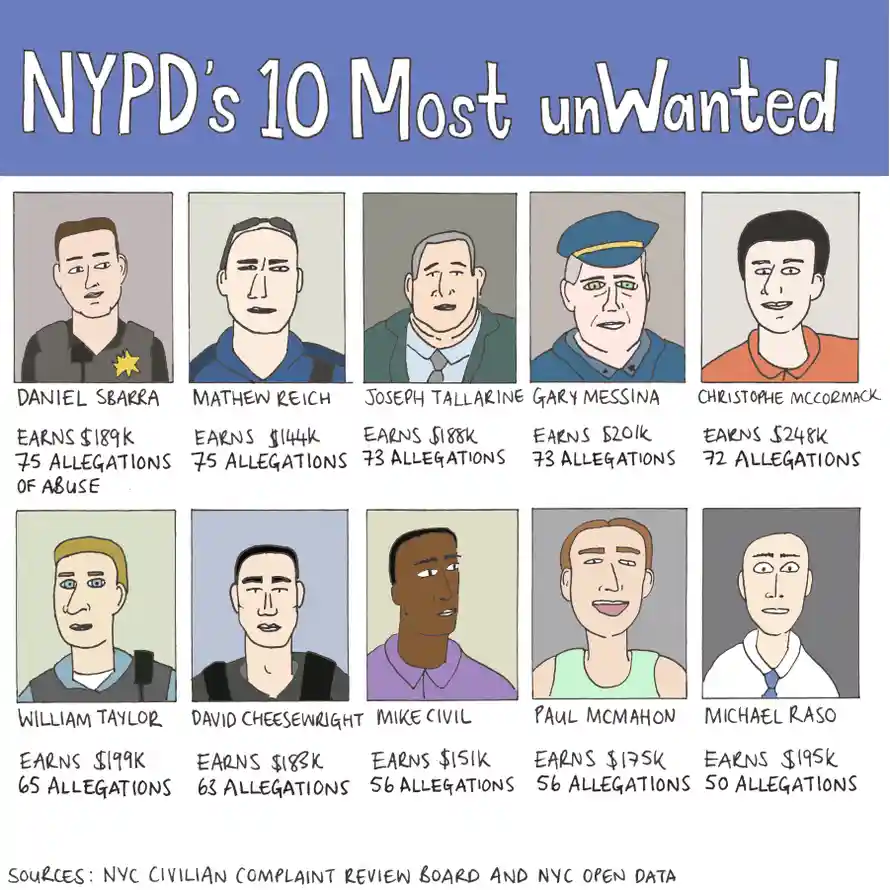

# Introduction
### Goal: predict the outcome of an NYPD allegation based on officer and complainant features
* This is a classification problem: I will use selected features about allegations to predict the final outcome, which is a categorical variable.

### Dataset
* This dataset contains data on 12,000 civilian complaints filed against New York City police officers. 
* In order to predict the outcome of NYPD allegation, we will first build a baseline model using simple features and Sklearn pipelines. 
* Next, we will add in more features and some engineered features to further perfect the prediction model.

### Target variable: "outcome_description". 
* I want to explore whether police complaints are handled with fairness and this feature is the best variable to reflect that. I want to explore whether certain conditions of the allegation would result in different allegation outcomes.
    * I will transform the "outcome_description" variable to a binary classification.
    * If outcome == 1 --> the accused police officer is arrested/summoned/other.
    * If outcome == 0 --> no arrest made or summons issued

### Evaluation metric: F-1 Score
* In this model, simple accuracy is not enough
* In evaluating whether FN or FP are more detrimental, I decided that: letting a police officer with misconduct remain in force for more unjust police action is worse than the inconvenience caused by investigating police with proper conduct. Recall measures the proportion of positives correctly identified and penalize FN.
    * However, simply focusing on the FN is not enough. Out of all the ones classified as positive (should be disciplined), we also want to make sure that we're not classifying too many good officers as needing discipline. That will diverge resources on actual police work and cause complaints within the department. 
    * Therefore I chose F-1 score to balance out the FP and FN and assess the model on its ability to predict bad officers while not inconveniencing too many good ones.

# Baseline Model
### Data Exploring:
* Imputing NaN values:
    * For quantitative variables: mos_age_incident and complainant_age_incident, I imputed the NaN values with the mean of the ages
    * For categorical variables: mos_ethnicity, most_gender, complainant_ethnicity, complainant_gender and fado_type, I imputed the NaN values with the most commonly appeared categories. 
    * I decided to use mean and most commonly used category because they encompass the most relatively representative value of each categories.
* Transforming outcome column
    * The outcome I want to predict is the outcome of allegation. However, since the allegation_description columns encompasses many different types of allegation outcome, I decided to just separate them into actions taken vs. no actions taken.
    * If the outcome contains "No arrest", it means that the allegation didn't go through, and I will represent it with a classification 0.
    * For any other outcomes, there are certain actions taken against the accused, whether that be arrested, summoned or investigated, and I will represent it with a classification 1.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pandas.util.testing as tm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [44]:
# loading dataset
nypd_file = os.path.join('data', 'allegations.csv')
nypd = pd.read_csv(nypd_file)
# imputing for NaN values
# create binary classifier "is_penalized" from "outcome_description" 
nypd["rank_incident"] = nypd["rank_incident"].fillna(nypd["rank_incident"].value_counts().idxmax())
nypd["mos_age_incident"] = nypd["mos_age_incident"].fillna(nypd["mos_age_incident"].mean())
nypd["complainant_age_incident"] = nypd["complainant_age_incident"].fillna(nypd["complainant_age_incident"].mean())
nypd["mos_ethnicity"] = nypd["mos_ethnicity"].fillna(nypd["mos_ethnicity"].value_counts().idxmax())
nypd["mos_gender"] = nypd["mos_gender"].fillna(nypd["mos_gender"].value_counts().idxmax())
nypd["complainant_ethnicity"] = nypd["complainant_ethnicity"].fillna(nypd["complainant_ethnicity"].value_counts().idxmax())
nypd["complainant_gender"] = nypd["complainant_gender"].fillna(nypd["complainant_gender"].value_counts().idxmax())
nypd["not_arrested"] = nypd["outcome_description"].str.contains("No arrest")
def replace_outcome(row):
    if row == True:
        return 0
    else:
        return 1
nypd["is_penalized"]= nypd["not_arrested"].apply(replace_outcome)
nypd.head(5)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,not_arrested,is_penalized
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),True,0
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),False,1
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),False,1
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges),True,0
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,Male,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A),False,1


### Feature:
* The 3 main features I chose for the baseline models is: allegation
    * The main purpose of this baseline model is to explore whether specific allegations are easier to get out of or not. 
    * I used a OneHotEncoder() to transform this categorical variable. 


### Choice of Classifier
* DecisionTreeClassifier
    * I chose DecisionTreeClassifier with a default max_depth as the baseline model classifier. 
    * I chose DecisionTree because the tree structure allows each add-on feature to sway or determine the result of the classification.

### Interpret F-1 Score
* The resulting F-1 score from the baseline model is approximately 0.72.
    * This number indicates the balance between FP and FN. 
    * Since the baseline model only includes allegation of the officer and doesn't consider any features of the complainant. I will further develop my model with more features and specially engineered features. 
    * This is also the specific allegation instead of the top-level category of allegation. The allegation being so specific could result in overfitting. Therefore in developing my final model, I will use fado_type, which is the more top-level type of allegation, to allow more generalization within the model.

In [4]:
# train - test split
nypd["allegation"] = nypd["allegation"].fillna(nypd["allegation"].value_counts().idxmax())
bX = nypd[["allegation"]]
by = nypd["is_penalized"]
bX_train, bX_test, by_train, by_test = train_test_split(bX, by, test_size=0.3)

# ColumnTransformer
nom_trans = ["allegation"]
nom_transform = OneHotEncoder(handle_unknown = "ignore")
preproc = ColumnTransformer(transformers=[('nominal_extraction', nom_transform, nom_trans)], remainder='passthrough')
base_pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])
base_pl.fit(bX_train, by_train)
base_preds = base_pl.predict(bX_test)
b_f1 = metrics.f1_score(by_test, base_preds)
b_f1

0.7249154453213077

# Final Model
### Feature Engineering
* is_same_ethnicity
    * I want to investigate whether the police and complainant having different ethnicity will impact the outcome of allegation because of the racial disparities in the police system
    * This new column is a boolean column that indicates whether the police and complainant have the same ethnicity
* age_difference --- quantitative
    * A younger complainant against an older officer will likely be taken less seriously than vice versa because of seniority construct. Therefore I want to investigate whether age difference is correlated to the result of the allegation. 
    * This column is obtained by subtracting complainant_age_incidence from mos_age_incident. 

In [47]:
# ordinal: FunctionTransformer for "rank_incident"
def helper(df):
    def transform_rank(rank):
        if rank == "Police Officer": return 1
        elif rank == "Detective": return 2
        elif rank == "Sergeant": return 3
        elif rank == "Lieutenant": return 4
        elif rank == "Captain": return 5
        elif rank == "Deputy Inspector": return 6
        elif rank == "Inspector": return 7
        elif rank == "Chiefs and other ranks": return 8
        else: return 0
    return df["rank_incident"].apply(transform_rank).values.reshape(-1,1)

# binary: same or different ethnicity
nypd["is_same_ethnicity"] = (nypd["mos_ethnicity"] == nypd["complainant_ethnicity"])
# quantitative: the age difference between police & complainant
nypd["age_difference"] = nypd["mos_age_incident"] - nypd["complainant_age_incident"]
nypd["is_same_ethnicity"].mean()

0.2212063073325739

### Final Model Features
* The baseline model only covered allegation reasons, which doesn't incorporate any information on the officer and complainant. 
* Therefore for the final model, I'm using complainant gender, officer gender, whether officer and complainant are the same ethnicity, high level allegation type, rank of officer at the incident and age difference.
* OneHotEncoder
    * mos_gender, complainant_gender: The gender of officer and complainant will likely play an impact on the result of allegation. For example, a female complainant against a male officer might be harder to resolve than vice versa.
    * fado_type: This is the high level category of allegation. Based on the seriousness of the allegation, and investigation might get different attention from law enforcement, therefore resulting in different outcomes.
* FunctionTransformer
    * rank_incident: After looking up the official police ranking of United States, I created a helper funtion to assign numbers to officer ranking, giving high level ranks more weight than low rank officers. My assumption is that higher ranked officers might have more ways to get out of an allegation than low rank officers. Therefore I used a function transformer to give weights to this variable.
* Pass Through
    * Boolean: is_same_ethnicity
        * This is the engineered feature indicating whether officer and complainant are of the same ethnicity.
    * Quantitative: age_difference
        * This is the engineered feature indicating the age difference between officer and complainant. 

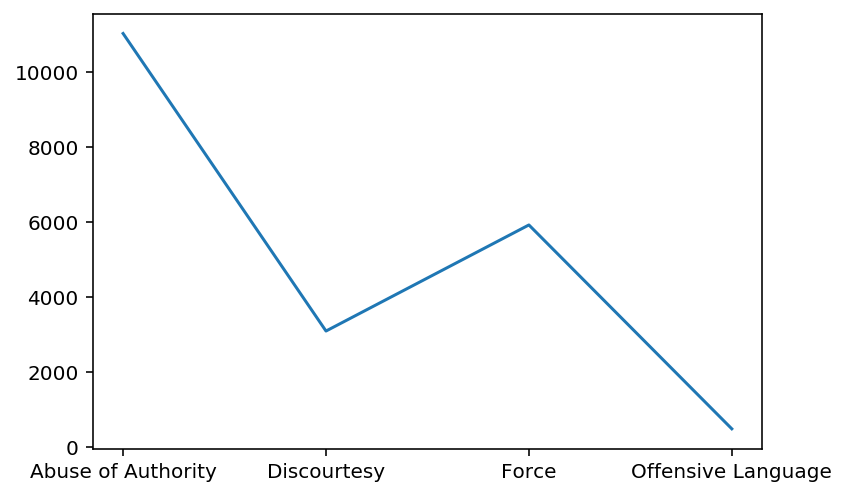

In [27]:
outcome_type = nypd.groupby("fado_type").sum()["is_penalized"]
plt.plot(outcome_type)

### Final Model Pipleline
* Classifier: RandomForestClassifier
    * RandomForestClassifier fits data on varies subsets of the dataset and takes the average for better prediction accuracy. 
        * Since we do have a lot of variables and uncertainties in the dataset, I decided to use this classifer to best average out uncertainties.
* Pipeline: 
    * Column Transformer: OneHotEncoder for categorical variables, FunctionTransformer for rank at incident, pass through boolean variable is_same_ethnicity and quantitative variable age_difference.
    * Regressor: RandomForestClassifier with max_depth of 7.
* Interpreting F-1 Score:
    * The average f1 score has drastically improved to around 0.76. Which indicates that this model can better balance FN and FP to prevent inconveniencing the innocent but also make sure the guilty are penalized.

In [7]:
# 2nd model: engineered features
import sklearn.preprocessing as pp
X = nypd[["mos_gender","complainant_gender", "is_same_ethnicity", "fado_type", "rank_incident", "age_difference"]]
y = nypd.is_penalized
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

rank_trans = ["rank_incident"]
# rank_transformation = Pipeline(steps=[
#     ('intenc', pp.OrdinalEncoder()),  # converts to int
#     ('onehot', pp.OneHotEncoder())     # output from Ordinal becomes input to OneHot
# ])
rank_transformation = FunctionTransformer(helper, validate = False)
ohe_trans = ["mos_gender", "complainant_gender","fado_type"]
ohe = OneHotEncoder(handle_unknown='ignore')
preproc = ColumnTransformer(transformers = [("ohe", ohe, ohe_trans),("transform_rank", rank_transformation, rank_trans)], remainder = "passthrough")
pl = Pipeline(steps = [("preprocessor", preproc), ("classifier", RandomForestClassifier(max_depth = 7, min_samples_leaf = 2, min_samples_split = 5))])
pl.fit(X_train, y_train)
preds = pl.predict(X_test)
f1 = metrics.f1_score(y_test, preds)
f1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7561881967626126

### GridSearch to find best parameter

In [8]:
parameters = {
    'classifier__max_depth': [2,5,7,13,18,None], 
    'classifier__min_samples_split':[2,5,10,15,20],
    'classifier__min_samples_leaf':[2,7,10,15,20]
}
grid_search = GridSearchCV(pl, parameters, cv=5)
grid_search.fit(X_train, y_train)
best_param = grid_search.best_params_

# Fairness Evaluation
### Why is this important? --- Data & Models have power in real life
* Accuracy is misleading
    * While accuracy can showcase the general performance of a prediction pipeline, if there is disproportionate inaccuracy within certain groups, that indicates that our model is biased.
    * For example, if the outcome of this model is going to determine how much resources are spent on investigations, then if a certain group of people are disproportionately mis-predicted, it will have drastic negative impact towards their life. 
* Assess fairness
    * In this section, I will use a permutation test to shuffle feature labels and run the same prediction pipeline.
    * If shuffling label doesn't show significant change in prediction outcome, then we can conclude that the model is fair in general.
    
    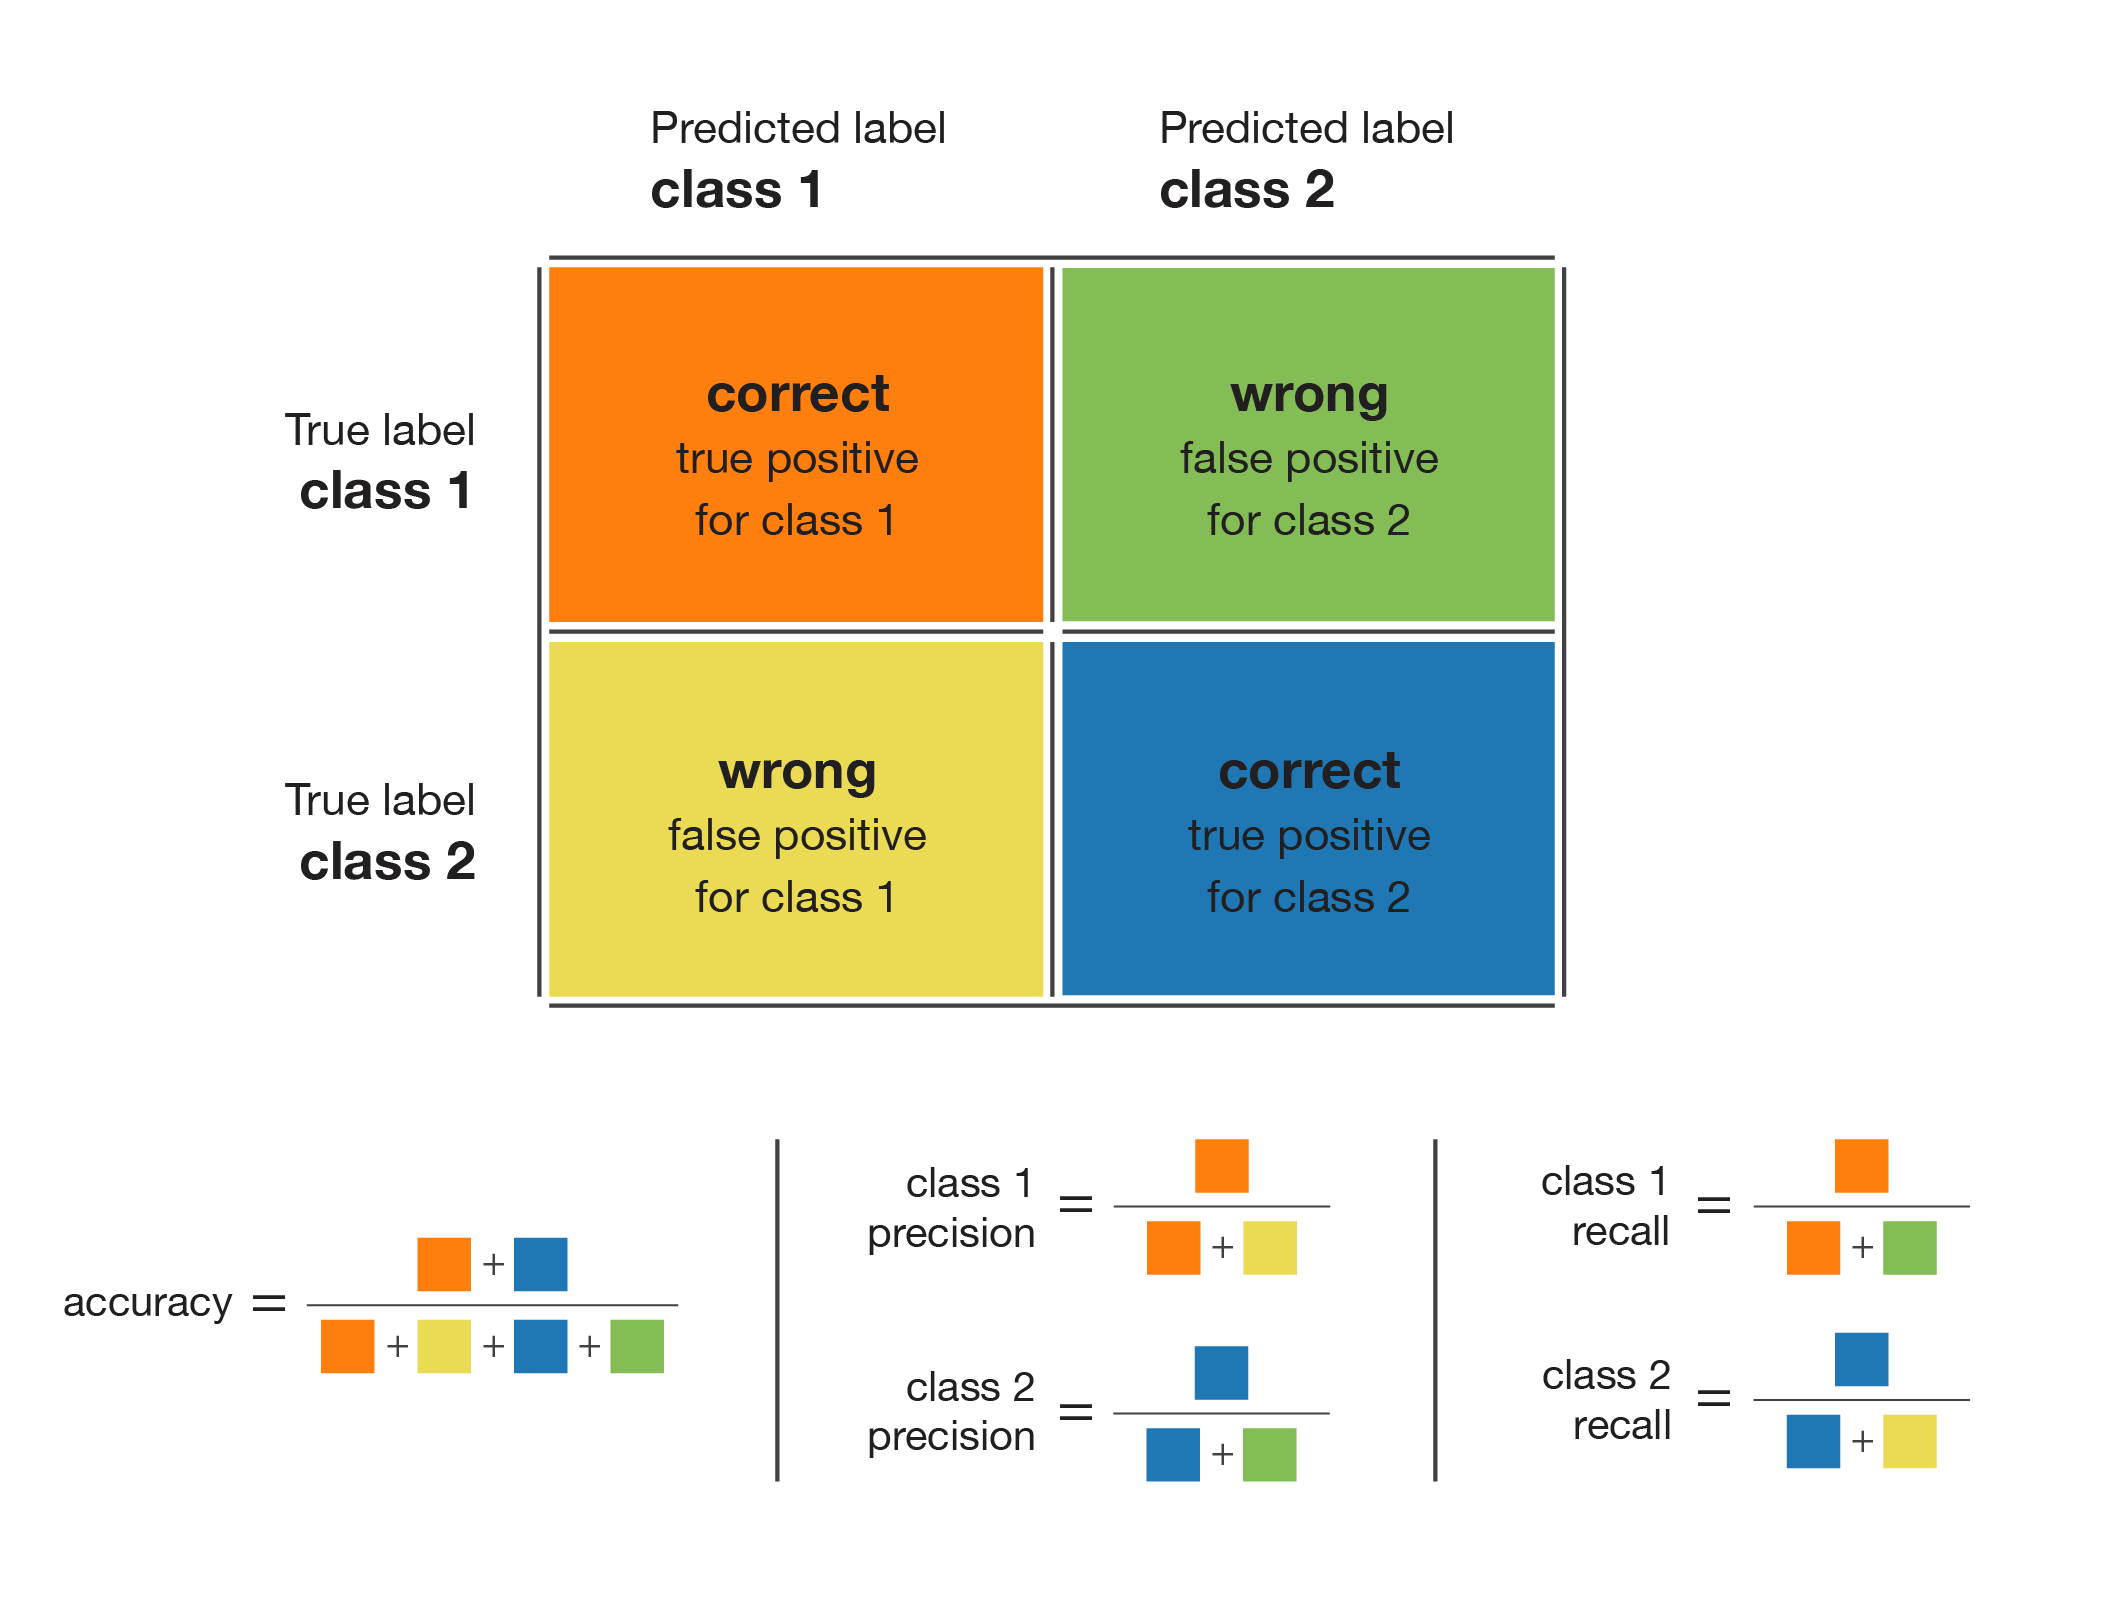

### Criteria
* is_same_ethnicity
    * I want to explore whether the model is biased based on whether police and complainant have the same ethnicity.
    * 22.12% of the cases have two sides of the same ethnicity, therefore we have a class imbalance problem.
    * The following process and the result of the inference test shows that this model is not biased against the is_same_ethnicity criteria.

### Process
* Obtain observed value:
    * I grouped the data by is_same_ethnicity, applied a lambda function to obtain the f1 score of each group and obtained the absolute difference between the two groups.
    * Observed value --- 0.014239836133925432
    * The observed value is relatively very small. However, in order to truly show that the model genralizes, I will use the following iteration mechanism to show fairness.
* Hypothesis (Permutation) Test
    * Null Hypothesis: the model performs equally well for those cases of the same ethnicity and those without.
    * Alternative Hypothesis: the model performs differently for those with the same ethnicity and without.
    * Significant level: 0.01
    * Iterative Process:
        * For each iteration, I shuffled the is_same_ethnicity label and repeated the process to obtain observed value. 
        * I appended all the sampled f1_scores into a list
        * I counted the number of f1_scores that are greater than the observed value, took the average and obtained the p-value

In [34]:
parity = X_test
parity["predicted"] = preds
parity["y_test"] = y_test
obs = parity.groupby("is_same_ethnicity").apply(lambda x: metrics.f1_score(x.y_test, x.predicted)).diff().abs().iloc[-1]
stats  = []

for _ in range(500):
    s = (
        parity[['is_same_ethnicity', 'predicted', 'y_test']]
        .assign(is_same_ethnicity=parity.is_same_ethnicity.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_same_ethnicity')
        .apply(lambda x: metrics.f1_score(x.y_test, x.predicted))
        .diff().abs()
        .iloc[-1]
    )
    stats.append(s)
pval = (obs >= pd.Series(stats)).mean()
obs, pval

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0.002910312876959975, 0.114)

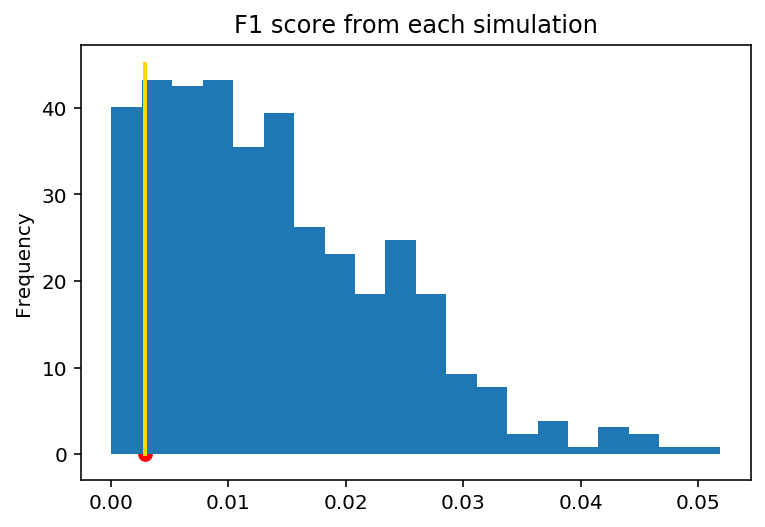

In [42]:
pd.Series(stats, name='Stats').plot(
    kind='hist', 
    bins=20,
    title='F1 score from each simulation',
    density=True
)
plt.scatter(obs, 0, color='red', s=40);
plt.plot([obs, obs], [0, 45], color='gold', lw=2);

### Interpretation
* Pval = 0.526
    * The obtained pval of 0.526 is way greater than the significant level, which means that we have enough evidence to show that our model performs <b>fairly</b>. 

# Conclusion & Discussion
* Goal: 
    * The goal of our model was to: "Predict the outcome of an NYPD allegation based on officer and complainant features". We created a prediction pipeline from a dataset of roughly 33,000 allegations each recording details about the ethnicity and gender of officer and complainant, age difference, reasons for allegation and the rank of the officer. Through building the baseline model and then expanding to include all the above features, we saw an increase in F-1 score, which indicates that our model performs accurately while balancing false positives and false negatives. 
    
* Fairness Evaluation: 
    * We also performed permutation testing to make sure that the model performs equally well for cases when officer and complainant have the same ethnicity versus cases of different ethnicity. This indicates that, if our model is used to allocated resources or influence the outcome of future allegations, it will not be biased against one case over another. Making sure model is fair is equally important as making sure the model is accurate.
    
* Limitation:
    * One limitation of our model is that we generalize the outcome of prediction to "any action taken" and "no action taken" while there are many types of outcome such as arrest, summoned, investigated etc. A further improvement we can make is to make each outcome description a predicted outcome. While it does make the model more fit to the dataset, the resources involved into building the model and the potential outcome of that detailed prediction could be limited. 
    
* Impact: 
    * The impact of this police allegation prediction model demonstrate the potential of data anlysis in government resource allocation. 
    * NYPD is New York's third largest agency, commanding \$10.9 Billion in 2020.
    * A model that is accurate and fair can be used to allocate funding more efficiently. Especially afte the police protests this year, the funding saved from smart allocation and planning can be used to create more educational program that can impact the society in a long term.
